In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import plotly.express as px
import pandas as pd

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

# EDA of fashion sales transaction data

This notebook serves as a first exploration of the data. After loading & parsing the data the following analysis tasks are performed:
* distribution of styles -- both in terms of article features and style groups and with regard to revenue and numbers of units sold
* evolution of the average number of units with time with reference to public holidays
* price distribution of the three different prices, grouped by the orginal price
* price evolution for the three different prices
* evolution of units sold comparing the differnt style categories

## Load data

In [3]:
from fashion_sales_forecast import config

df_transactions = pd.read_csv(config.SALES_DATA_PATH)

In [4]:
display(df_transactions.head())

article_id                                  style_color_group                                        style_group       level1 level2    level3         level4 sales_channel transaction_date  units_sold  original_price  sales_price  final_price  is_promotion  month_of_launch season_start_date season_end_date  current_season  initial_season
0  7c478b2a19cf829fce778dfa644478b8639e3552765887...  8975b6409175f438d071392c28591bd0f79cb88cb72b20...  ca06da7963036e9655dfb97d44721e692b2cdd162484c3...  FashionClub  Women  T-shirts  short-sleeved   Online Shop       2022-01-01          10           15.99        15.99        15.99             0                7        2022-06-01      2023-07-14          202402          202207
1  7c478b2a19cf829fce778dfa644478b8639e3552765887...  8975b6409175f438d071392c28591bd0f79cb88cb72b20...  ca06da7963036e9655dfb97d44721e692b2cdd162484c3...  FashionClub  Women  T-shirts  short-sleeved   Online Shop       2022-01-02          10           15.99        15.99        15.92             0                7        2022-06-01      2023-07-14          202402          202207
2  7c478b2a19cf829fce778dfa644478b8639e3552765887...  8975b6409175f438d071392c28591bd0f79cb88cb72b20...  ca06da7963036e9655dfb97d44721e692b2cdd162484c3...  FashionClub  Women  T-shirts  short-sleeved   Online Shop       2022-01-03           5           15.99        15.99        15.91             0                7        2022-06-01      2023-07-14          202402          202207
3  7c478b2a19cf829fce778dfa644478b8639e3552765887...  8975b6409175f438d071392c28591bd0f79cb88cb72b20...  ca06da7963036e9655dfb97d44721e692b2cdd162484c3...  FashionClub  Women  T-shirts  short-sleeved   Online Shop       2022-01-04          20           15.99        15.99        15.85             0                7        2022-06-01      2023-07-14          202402          202207
4  7c478b2a19cf829fce778dfa644478b8639e3552765887...  8975b6409175f438d071392c28591bd0f79cb88cb72b20...  ca06da7963036e9655dfb97d44721e692b2cdd162484c3...  FashionClub  Women  T-shirts  short-sleeved   Online Shop       2022-01-05           7           15.99        15.99        15.94             0                7        2022-06-01      2023-07-14          202402          202207

## Clean data

In [5]:
# no missing data - no imputation needed
df_transactions.isnull().sum()

article_id           0
style_color_group    0
style_group          0
level1               0
level2               0
level3               0
level4               0
sales_channel        0
transaction_date     0
units_sold           0
original_price       0
sales_price          0
final_price          0
is_promotion         0
month_of_launch      0
season_start_date    0
season_end_date      0
current_season       0
initial_season       0
dtype: int64

## Data exploration
* parsing dataframe to helpful column dtypes

In [17]:
from fashion_sales_forecast.utils import parse_initial_dataframe

df_transactions = parse_initial_dataframe(df_transactions)
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12053 entries, 0 to 12052
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   article_id         12053 non-null  category      
 1   style_color_group  12053 non-null  category      
 2   style_group        12053 non-null  category      
 3   level1             12053 non-null  category      
 4   level2             12053 non-null  category      
 5   level3             12053 non-null  category      
 6   level4             12053 non-null  category      
 7   sales_channel      12053 non-null  category      
 8   transaction_date   12053 non-null  datetime64[ns]
 9   units_sold         12053 non-null  int64         
 10  original_price     12053 non-null  float64       
 11  sales_price        12053 non-null  float64       
 12  final_price        12053 non-null  float64       
 13  is_promotion       12053 non-null  bool          
 14  month_

### Histograms of numeric columns

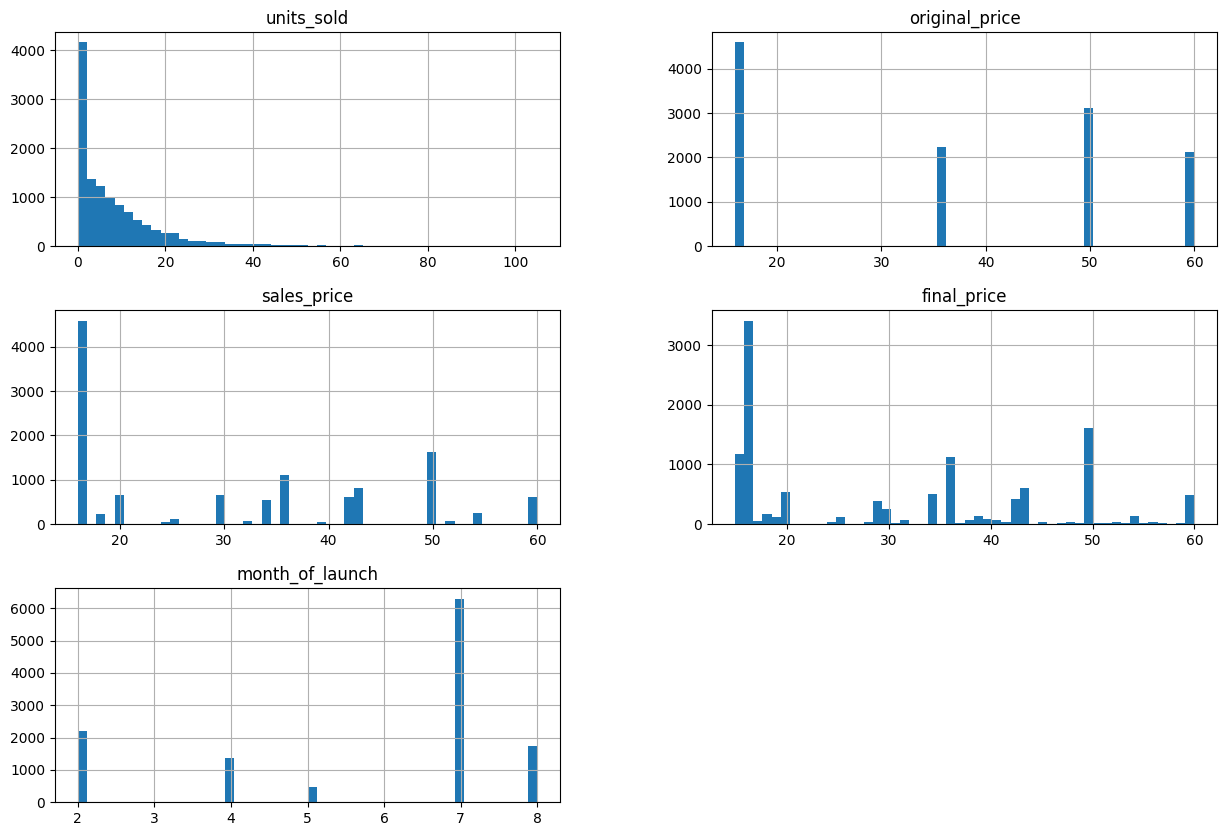

In [18]:
numerical_columns = [
    "units_sold",
    "original_price",
    "sales_price",
    "final_price",
    "month_of_launch",
]

(df_transactions.filter(items=numerical_columns).hist(bins=50, figsize=(15, 10)));

### Style distributions

In [8]:
num_articles = df_transactions["article_id"].nunique()
num_style_groups = df_transactions["style_group"].nunique()
num_style_color_groups = df_transactions["style_color_group"].nunique()


print(f"number of products: {num_articles}")
print(f"number of style groups: {num_style_groups}")
print(f"number of style-color groups: {num_style_color_groups}")

number of products: 22
number of style groups: 8
number of style-color groups: 22


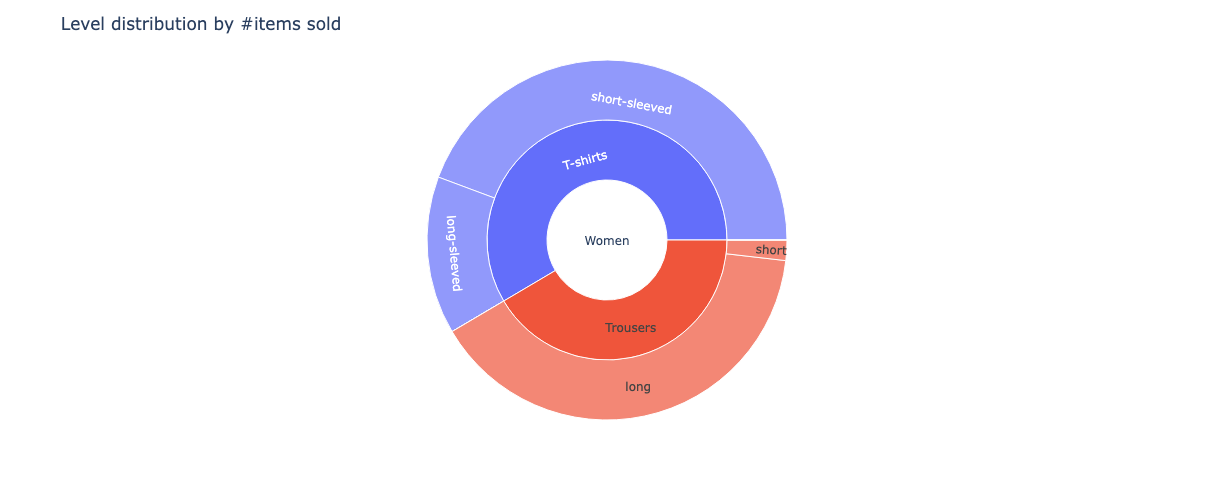

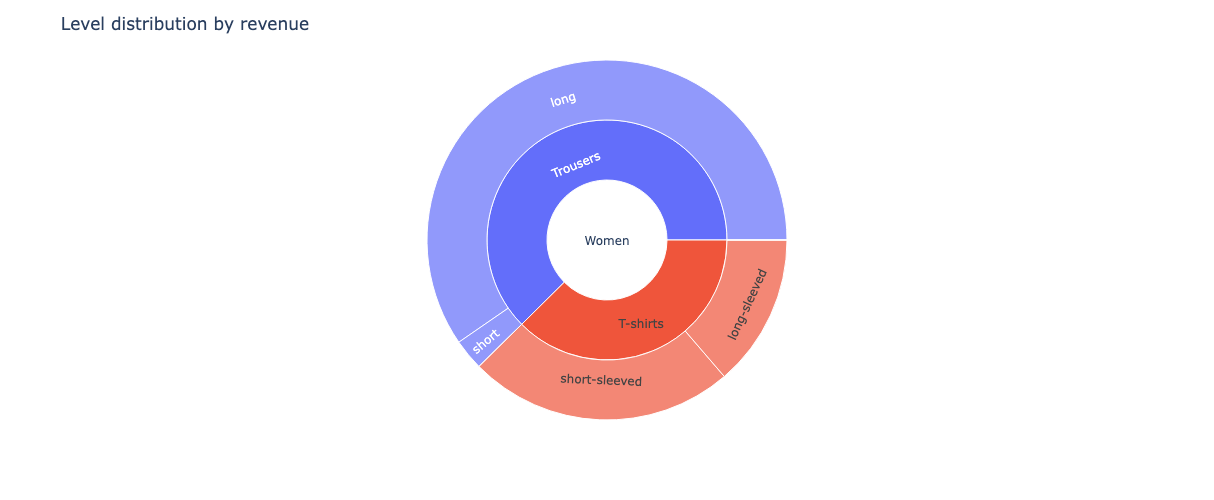

In [20]:
df_levels = (
    df_transactions.groupby(
        by=["level1", "level2", "level3", "level4"], as_index=True, observed=True
    )
    .agg(
        {
            "units_sold": "sum",
            "original_price": "mean",
            "final_price": "mean",
        }
    )
    .reset_index(names=["level1", "level2", "level3", "level4"])
    .assign(revenue=lambda df: df["units_sold"] * df["final_price"])
)


fig = px.sunburst(df_levels, path=["level2", "level3", "level4"], values="units_sold")
fig.update_layout(title="Level distribution by #items sold", height=500, width=500)
fig.write_html("plots/file.html")
fig.show()

fig = px.sunburst(df_levels, path=["level2", "level3", "level4"], values="revenue")
fig.update_layout(title="Level distribution by revenue", height=500, width=500)
fig.show()

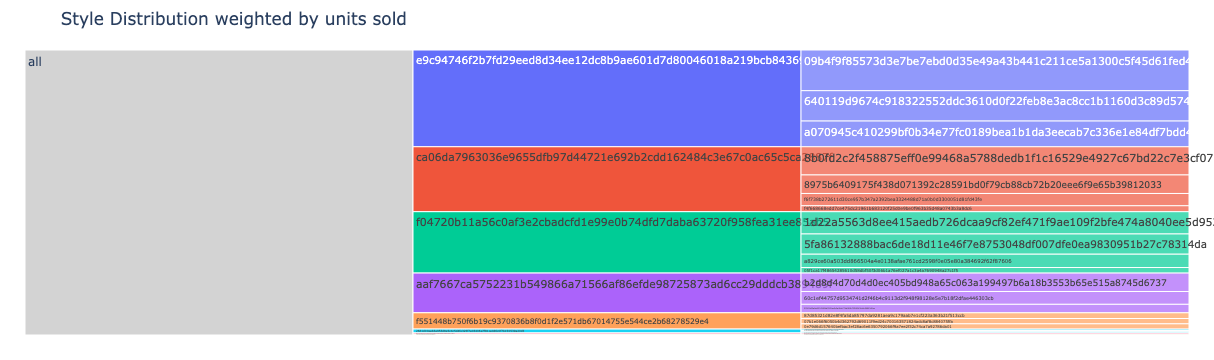

In [10]:
df_styles = (
    df_transactions.groupby(by=["style_group", "style_color_group"], as_index=True)
    .agg(
        {
            "units_sold": "sum",
            "original_price": "mean",
            "final_price": "mean",
        }
    )
    .reset_index(names=["style_group", "style_color_group"])
    .assign(revenue=lambda df: df["units_sold"] * df["final_price"])
)


# even distribution among style groups
fig = px.icicle(
    df_styles, path=[px.Constant("all"), "style_group", "style_color_group"]
)
fig.update_traces(root_color="lightgrey")
fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    height=600,
    title="Style Distribution",
)
fig.show()


# style groups weighted by number of sold units
fig = px.icicle(
    df_styles,
    path=[px.Constant("all"), "style_group", "style_color_group"],
    values="units_sold",
)
fig.update_traces(root_color="lightgrey")
fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    height=600,
    title="Style Distribution weighted by units sold",
)
fig.show()

### Evolution of sales

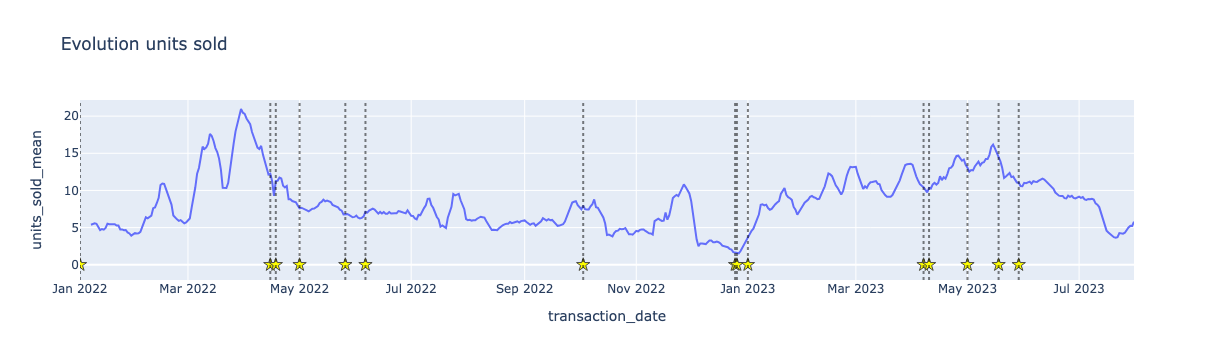

In [11]:
from fashion_sales_forecast.visualizations import plot_time_series_with_holidays
from fashion_sales_forecast.utils import compute_rolling_mean

df_transactions_rolling = compute_rolling_mean(
    df_transactions, columns=["units_sold"], days=7
)

plot_time_series_with_holidays(
    df_transactions_rolling, value_col="units_sold_mean", title="Evolution units sold"
)

### Price distribution

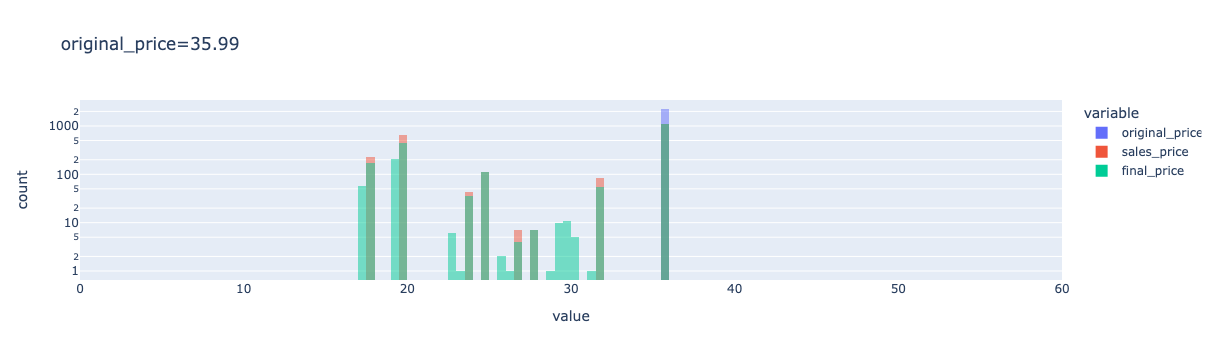

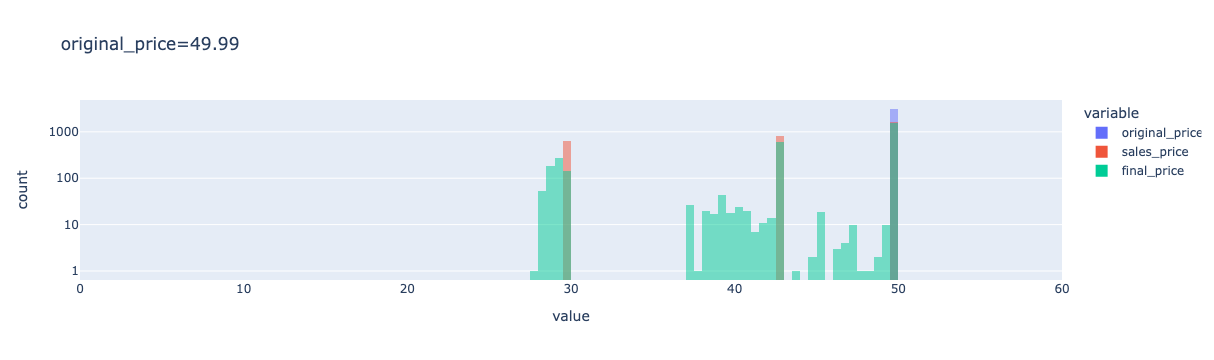

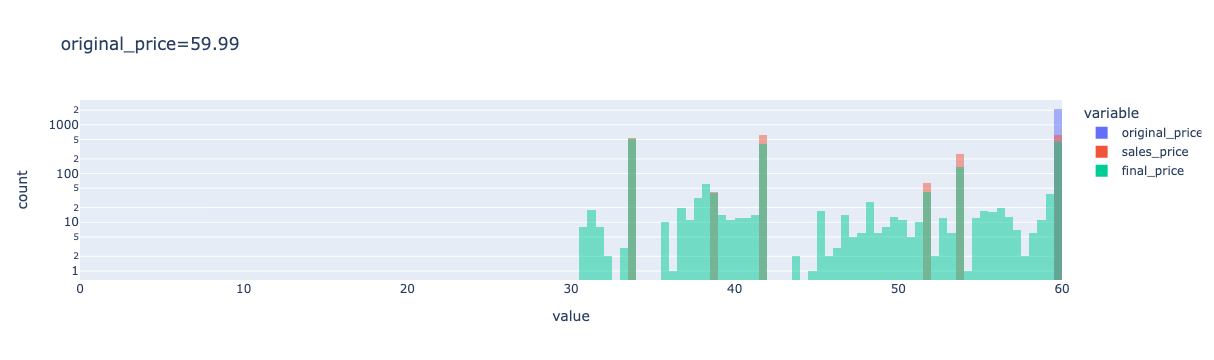

In [12]:
from fashion_sales_forecast.utils import filter_by_price
from fashion_sales_forecast.visualizations import plot_price_histogram


original_prices = sorted(df_transactions["original_price"].unique())

for original_price in original_prices:
    df_original_price = df_transactions.pipe(
        filter_by_price, price=original_price, price_column="original_price"
    )
    plot_price_histogram(
        df_original_price,
        title=f"{original_price=}",
    )

### Price evolution

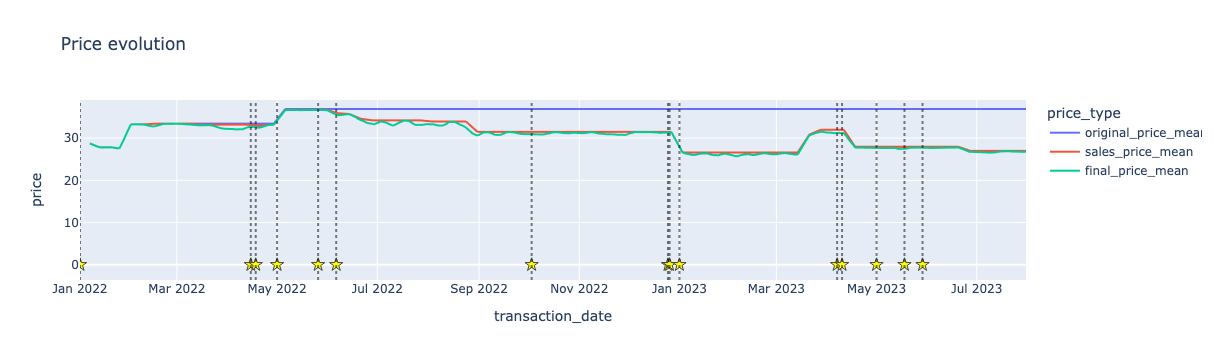

In [13]:
from fashion_sales_forecast.visualizations import plot_time_series_with_holidays
from fashion_sales_forecast.utils import compute_rolling_mean


def plot_price_evolution(df: pd.DataFrame, title: str = "Price evolution"):
    df_transactions_rolling = compute_rolling_mean(
        df, columns=["original_price", "sales_price", "final_price"], days=7
    )
    df_transactions_rolling = df_transactions_rolling.melt(
        id_vars=[config.DATE_COL],
        value_vars=["original_price_mean", "sales_price_mean", "final_price_mean"],
        var_name="price_type",
        value_name="price",
    )

    plot_time_series_with_holidays(
        df_transactions_rolling,
        value_col="price",
        color_col="price_type",
        title=title,
    )


plot_price_evolution(df_transactions)

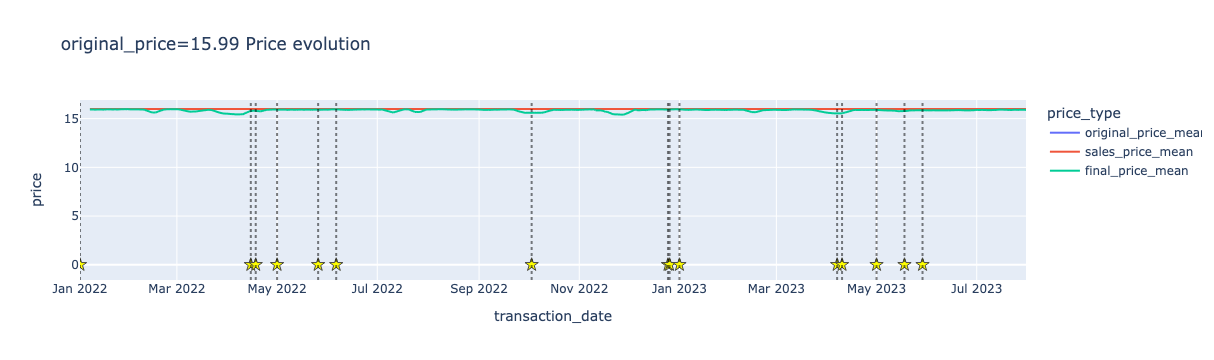

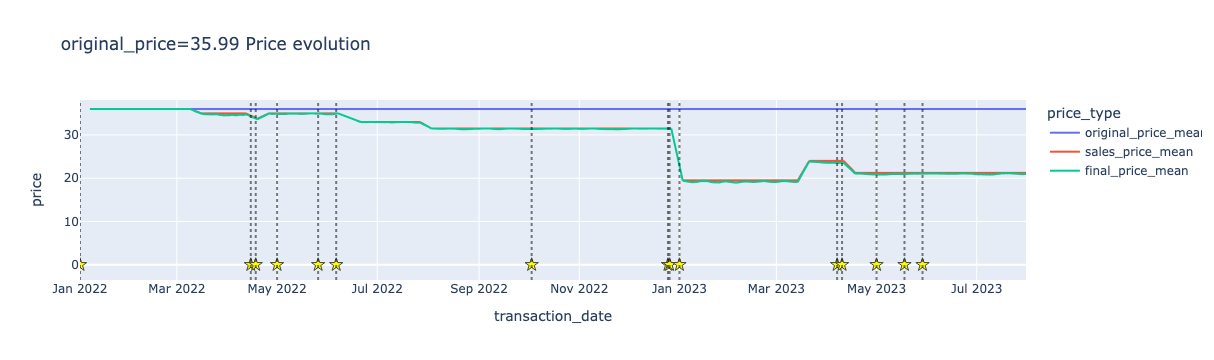

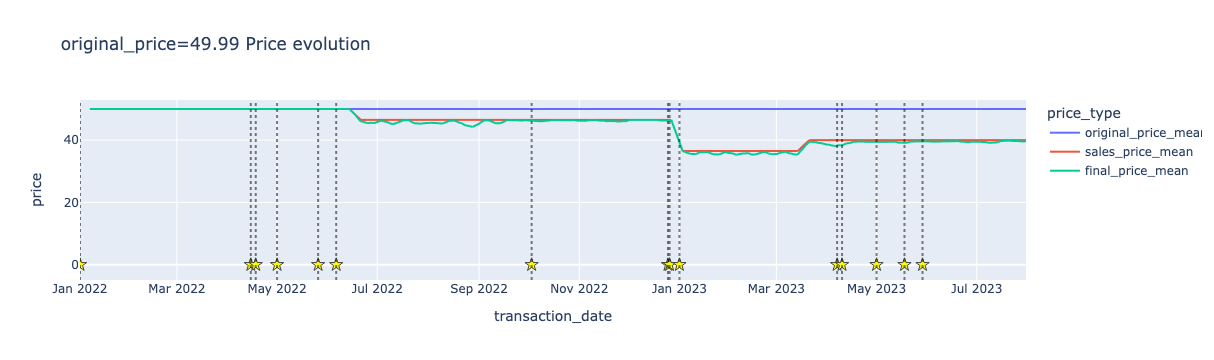

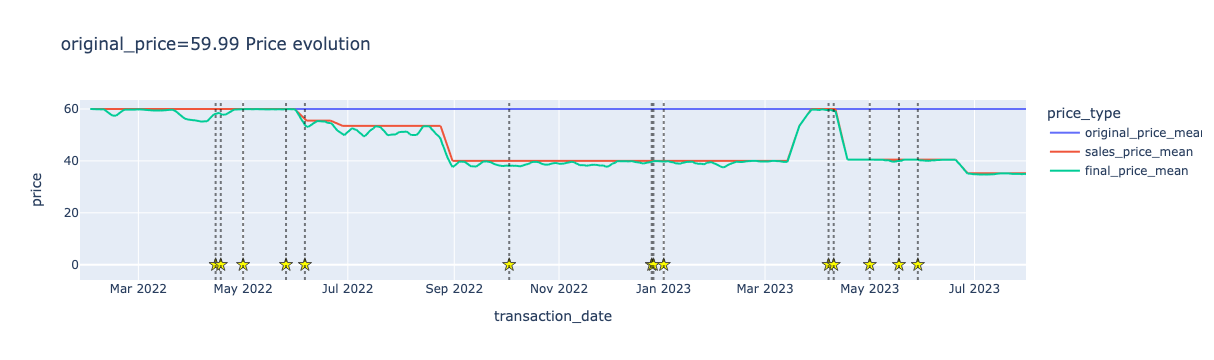

In [14]:
from fashion_sales_forecast.visualizations import plot_time_series_with_holidays
from fashion_sales_forecast.utils import compute_rolling_mean
from fashion_sales_forecast.utils import filter_by_price


original_prices = sorted(df_transactions["original_price"].unique())

for original_price in original_prices:
    df_transaction_original_price = filter_by_price(
        df_transactions, price=original_price
    )
    plot_price_evolution(
        df_transaction_original_price, title=f"{original_price=} Price evolution"
    )

### Evolution units sold by style

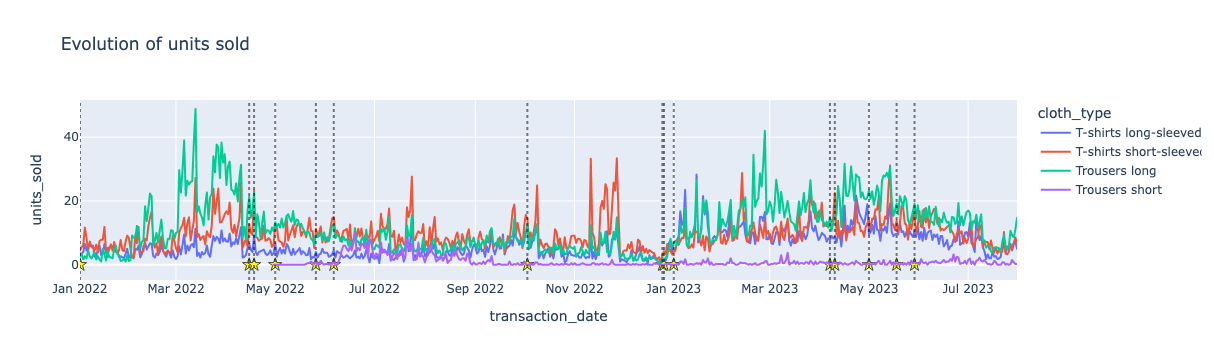

In [15]:
from fashion_sales_forecast.visualizations import plot_time_series_with_holidays
from fashion_sales_forecast.utils import compute_rolling_mean
from fashion_sales_forecast import config

df_transactions_type = (
    df_transactions.copy()
    .assign(
        cloth_type=lambda df: df.apply(
            lambda row: row["level3"] + " " + row["level4"], axis=1
        )
    )
    .groupby(by=[config.DATE_COL, "cloth_type"], as_index=False)
    .agg(units_sold=("units_sold", "mean"))
)

plot_time_series_with_holidays(
    df_transactions_type,
    value_col="units_sold",
    color_col="cloth_type",
    title="Evolution of units sold",
)